## Red Sequence Method Tutorial

Description:

0. NOTE: Running this code requires the file `massiv_cl.csv` which is a list of function positions.

1. Setting up the packages to be able to extract galaxies from Truth Catalogue using TAP. 

2.  Define functions that extract galaxies around known clusters positions returning `r` and `i` magnitude and redshift data. Define function that will plot color magnitude diagrams for each cluster, and then read in 149 cluster positions.
   
3. Plot the color-intercept versus redshift and calculate the best fit line using sigma clipping. These plots are made for redshifts in the range of `0.2-0.25` and `0.54-0.66`.

4. Conclusions

5. Exercises for the reader: Try different colors and redshift ranges. Add your own cluster catalogues, and make a color image of some of the clusters. Plot a few of the color magnitude diagrams that are not plotted. 


Author: Vicente Puga <br>
Contact Author: Louise Edwards ledwar04@calpoly.edu <br>
Last verified to run: 2023-04-02 <br>
Targeted learning level: beginner <br>

Credit: This notebook uses code from DP0 Tutorials 1 and 2

## Introduction 
Galaxy clusters can be visualized using color magnitude diagrams. And with use of the TAP and Matplotlib several of these figures can be made so that we can determine unique qualities of each cluster. The most significant quality pertaining to this notebook is the value associated with the red sequence. The red sequence is a unique feature that appears on the color magnitude diagram which can be quantified by assigning it an intercept value. In this notebook we will analyze the relationship between that intercept value and the redshift, or distance, of the galaxies collected. 

## 1. Setting up the Packages
Here you will be importing the packages required to use Matplotlib. Important data constants will also be imported to be able to use and manipulate the lsst data. 

This cell imports lsst data packages which we can use to call the data we need for plotting. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.modeling import models, fitting
from lsst.rsp import get_tap_service, retrieve_query

This cell imports lsst data packages which we can use to call the data we need for plotting. 

In [2]:
# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# To ignore some kinds of warnings
import warnings
from astropy.units import UnitsWarning

In this cell, some adjustment is done to the data displayed with pandas. 

In [3]:
pandas.set_option('display.max_rows', 200)
%matplotlib inline
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}


In [4]:
def sort_dataframe(df, sort_key='objectId'):
    df = df.sort_values(sort_key)
    df.set_index(np.array(range(len(df))), inplace=True)
    return df

In [5]:
service = get_tap_service("tap")

In [6]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

/tmp/ipykernel_11774/1189525124.py:1: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = get_tap_service()


Before we search from the database we need to set constants that specify the parameters of our search. Defining these constants makes it easier to code our search from the query. This will also help if the search parameters need to be changed, instead of going into the cell with the search code and changing each instance these values appear we can simply change the definitions of these constants. 

In [7]:
Mag_Min = 22.0 #The maximum magnitude of objects we want from our search
Mag_Max = 15.5 #The minimum magnitude of objects we want from our search

The magnitude scale defines larger values as dimmer objects and smaller values as brighter objects. Flux however works as one would expect, large values are brighter and smaller values are dimmer. Sometimes instead of using a range of magnitudes we can use a range of fluxes to describe our search. Here we do just that by using the conversion equation between magnitude and flux. The maximum and minimum flux values will be used in the search, however the same search could also be done with the previously defined `Mag_Min` and `Mag_Max`. 

In [8]:
Max_Flux = 10**((Mag_Max-31.4)/-2.5)
Min_Flux = 10**((Mag_Min-31.4)/-2.5)

print("Min Flux is, ", Min_Flux)
print("Max Flux is, ", Max_Flux)

Min Flux is,  5754.399373371561
Max Flux is,  2290867.65276777


FOR LOW Z NEEDS TO BE BASED ON BRIGHTEST GALAXY KIND OF ONLY!!!?!

## 2. Creating the Functions to Extract the Galaxies and Reading Cluster Centers

We will now define a function so that we can run multiple queries with one line of code. We will call this function `coordinate_loop`. We will make it a function of `x`, where `x` will be a list of ra and dec coordinates. To start off the function we simply write our a query of the galaxies we want to extract. We pick a search radius, `rad`, equal to 0.25 to minimize background galaxies and so that the search stays relatively close to the coordinate entered. This query will now search this radius for galaxies fitting the desired parameters. However there will be instances where the query returns an empty table. This is due to the search radius being too small. So we implement a while loop. This loop will be activated any time the length of the results table is equal to 0. And it will rerun the original query but with a slightly larger radius. It will continue to do this until the length of the results table is greater than 900 entries. As the loop collects its searches it also averages the redshift of all the galaxies in the search, and uses that value as the redshift value associated to the cluster. 

In [9]:
def coordinate_loop(x):
    #center_coords = SkyCoord(x, y, frame='icrs', unit='deg')
    rad=0.1 #0.1 for 0.11 redshift
    searchrad = str(rad)
    search_radius = 1.0*u.deg 
    use_center_coords = str(x)
    use_radius = searchrad
    #use SELECT TOP 10 for 0.11 redshift
    explore = service.search(
        "SELECT TOP 5 mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, "\
        "ts.redshift AS ts_redshift, "\
        "obj.coord_ra AS obj_coord_ra, "\
        "obj.coord_dec AS obj_coord_dec, "\
        "scisql_nanojanskyToAbMag(obj.r_cModelFlux) AS obj_cModelMag_r, "\
        "scisql_nanojanskyToAbMag(obj.i_cModelFlux) AS obj_cModelMag_i "\
        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
        "WHERE CONTAINS(POINT('ICRS', ra, dec), "\
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 "\
        "AND ts.truth_type = 1 "\
        "AND scisql_nanojanskyToAbMag(obj.r_cModelFlux) < " + str(Mag_Min) +\
        "AND scisql_nanojanskyToAbMag(obj.r_cModelFlux) > " + str(Mag_Max) +\
        "AND scisql_nanojanskyToAbMag(obj.i_cModelFlux)  <" + str(Mag_Min) +\
        "AND scisql_nanojanskyToAbMag(obj.i_cModelFlux)  >" + str(Mag_Max) +\
        "AND obj.detect_isPrimary = 1"\
        "AND is_variable = 0 " \
        "ORDER BY obj_cModelMag_r ASC")
    tab = explore.to_table().to_pandas()
    redmed=np.median(tab['ts_redshift'])
    redshifts_unlim.append(redmed)
    return(tab)

We will now write another loop which will plot color magnitude diagrams for each of the galaxy clusters used in the query. This loop takes in the r and i values of the galaxies queried so that it can make the plot, it also takes a variable called `clus` which will be defined later one. But it is in short a label for each cluster. In addition to plotting, this loop will also quantify the red sequence. And it does this by predicting the shape of the red sequence with a line of best fit. As mentioned before, the intercept value will be the way we quantify the red sequence. However, an issue arrizes in that the color magnitude diagrams are plotted on an inverse x axis. Meaning as you move further left you simple to infinite rather than reaching the y intercept. So we create our own intercept. We decide to make the point where magnitude equals 21 to be the intercept. This is the value we will use in furhter analysis to quantify the red sequence.  

In [10]:
def galaxy_plot(r, i, clus):
    fig = plt.figure(figsize=(8, 8))
    data = {'imag': i, 
            'rmag': r}
    data['rmi'] = data['rmag'] - data['imag']
    plt.title('Colour-Magnitude Diagram '+str(clus)+'')
    plt.xlim(22.2, 15.5)
    plt.ylim(-0.5, 1.5)
    plt.xlabel('r')
    plt.ylabel('r-i')
    plt.grid(True)
    x = data['rmag']
    y = data['rmi']

    #find line of best fit
    #initialize fitter
    fit = fitting.LinearLSQFitter()
    # initialize the outlier removal fitter
    or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=2)
    # initialize a linear model
    line_init = models.Linear1D()
    # fit the data with the fitter
    fitted_line, mask = or_fit(line_init, x, y)
    filtered_data = np.ma.masked_array(y, mask=mask)
    #gather slope and intercept
    m = fitted_line.slope.value
    b = fitted_line.intercept.value
    
    plt.scatter('rmag', 'rmi', s=6, color='blue', data=data)
    plt.plot(x, y, "o",color="black",fillstyle="none", label="Clipped Data")
    plt.plot(x, filtered_data, "o",color="black", label="Fitted Data")
    plt.plot(x, fitted_line(x), '--', color='purple', label='Fitted Model')
    plt.legend()

    plt.savefig('RedSequenceLine '+str(clus)+'.png')
    plt.close()
    slope = m
    #print('Slope is ', slope)
    yints = b
    #print('Y-Intercept is ', yint)
    int21=m*18+b 
    
    redint.append(int21)
    slopes.append(m)
    yint.append(b)
    #np.savetxt('name.dat', slopes)

Here we import a collection of coordinates pertaining to known clusters. We define the ra column as `x`, and the dec column as `y`. 

In [11]:
#nt1 = pandas.read_csv(r'localcl_cl.csv')
#nt2 = pandas.read_csv(r'massiv_cl-edit.csv')
# concatenating df1 and df2 along rows
#newtable = pandas.concat([nt1, nt2], axis=0)

#newtable = pandas.read_csv(r'localcl_cl.csv')
newtable = pandas.read_csv(r'two_red_ranges.csv') #both ranges, but not all the points
x=newtable['ra'].astype('string')
y=newtable['dec'].astype('string')
zed=newtable['redshift']

z = x + ', ' + y 
subjects = z.to_numpy()
zed = zed.to_numpy()


## 3. Putting Everything Together: Runing the loops and Calculating the Intercepts and Plotting Redshift v. Intercept

Taking the loops we defined earlier we can now put everything together into a loop which will run every coordinate in the list `subejcts`. In addition to collecting and plotting the galaxies, and their larger clusters, the loop will collect and append the redshift and red sequence intercept values to lists that can be used for the final step. 

This code may take several minutes to run (about 20)

In [12]:
slopes = []
yint = []
redint = []
redshifts_unlim= []
rcollect1=[]
icollect1=[]
coordinates= subjects
redINPUT = []
clnum=len(coordinates)
#for clus in range(0, clnum):
for clus in range(0, 100):
    #print(clus)
    #print(coordinates[clus], clnum)
    tab = coordinate_loop(coordinates[clus])
    redINPUT.append(zed[clus])
    r=tab['obj_cModelMag_r']
    i=tab['obj_cModelMag_i']
    rcollect1.append(r)
    icollect1.append(i)
    rs_plot = galaxy_plot(r, i, clus)
#    print(tab)
print(redshifts_unlim)
print(redINPUT)

[0.182707, 0.0490843, 0.0493178, 0.0484737, 0.0523355, 0.045436, 0.0453696, 0.0437921, 0.0437921, 0.0594648, 0.0334568, 0.0469418, 0.0628821, 0.216892, 0.0512057, 0.408991, 0.0518937, 0.157337, 0.0835595, 0.0520289, 0.0518937, 0.0730025, 0.0511471, 0.120574, 0.137563, 0.137264, 0.155603, 0.0766424, 0.050274, 0.083527, 0.127436, 0.288785, 0.125964, 0.126249, 0.124191, 0.0787746, 0.139674, 0.137178, 0.11591, 0.115303, 0.152295, 0.149168, 0.103457, 0.146167, 0.144002, 0.0455431, 0.131701, 0.103758, 0.151398, 0.144887, 0.109296, 0.128036, 0.0923541, 0.107924, 0.103009, 0.147558, 0.146869, 0.139725, 0.148471, 0.13803, 0.102632, 0.116585, 0.0661705, 0.0410414, 0.102626, 0.126207, 0.0997266, 0.130203, 0.117393, 0.127254, 0.11917, 0.119292, 0.116649, 0.115914, 0.115001, 0.138446, 0.137062, 0.103693, 0.108307, 0.136064, 0.135495, 0.138501, 0.0916314, 0.0998329, 0.107481, 0.111803, 0.141856, 0.0830789, 0.0805646, 0.125893, 0.0827162, 0.118143, 0.11753, 0.147492, 0.138338, 0.112962, 0.225783, 0.1

In [13]:
tab


,id_truth_type,match_objectId,ra,dec,truth_type,ts_redshift,obj_coord_ra,obj_coord_dec,obj_cModelMag_r,obj_cModelMag_i
0,10937504905_1,1325008268493349520,49.811597,-42.901312,1,0.111935,49.811598,-42.901312,15.981682,15.583018
1,10937510370_1,1325008268493347513,49.774237,-42.940120,1,0.148475,49.774238,-42.940119,17.148871,16.675431
2,10937504917_1,1325008268493348205,49.723954,-42.935190,1,0.112198,49.723956,-42.935189,17.345892,16.904565
3,10937500713_1,1324946695842204737,49.824045,-42.971568,1,0.072385,49.824045,-42.971568,17.604342,17.190166
4,10937504906_1,1325008268493350340,49.779090,-42.890758,1,0.111676,49.779092,-42.890759,17.725788,17.265204


The final step is to take all the values collect and test to see the trend between red sequence intercept and redshift. 

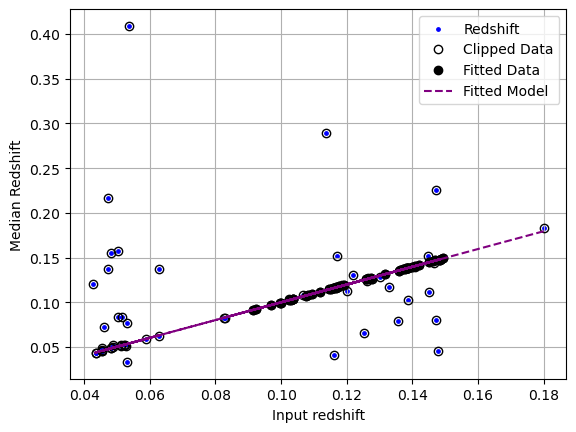

In [14]:
data = {'Redshift': redshifts_unlim, 
        'RedIN': redINPUT}

plt.scatter('RedIN', 'Redshift', s=6, color='blue', data=data)

#This sets axis range
#plt.xlim(23.2, 15.7)
plt.ylabel('Median Redshift')
plt.xlabel('Input redshift')
plt.grid(True)

y = np.array(data['Redshift'])
x = np.array(data['RedIN'])

#find line of best fit
#initialize fitter
fit = fitting.LinearLSQFitter()
# initialize the outlier removal fitter
# increase parameter 'sigma' for a include larger outliers
or_fit = fitting.FittingWithOutlierRemoval(fit, sigma_clip, niter=3, sigma=2)
# initialize a linear model
line_init = models.Linear1D()
# fit the data with the fitter
fitted_line, mask = or_fit(line_init, x, y)
filtered_data = np.ma.masked_array(y, mask=mask)
#gather slope and intercept
m = fitted_line.slope.value
b = fitted_line.intercept.value

plt.plot(x, y, "o",color="black",fillstyle="none", label="Clipped Data")
plt.plot(x, filtered_data, "o",color="black", label="Fitted Data")
plt.plot(x, fitted_line(x), '--', color='purple', label='Fitted Model')
plt.legend()
plt.show()

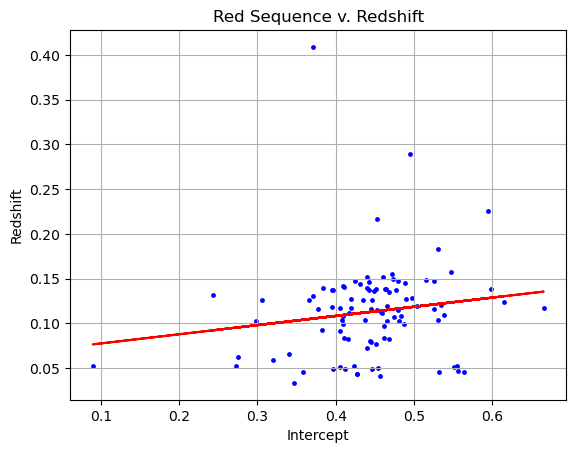

0.10237317564336122 0.06737607330331549


In [15]:
data = {'Redshift': redshifts_unlim, 
#data = {'Redshift': redINPUT,
        'Redint': redint}

plt.scatter('Redint', 'Redshift', s=6, color='blue', data=data)
plt.title('Red Sequence v. Redshift')

#This sets axis range
#plt.xlim(23.2, 15.7)
plt.ylabel('Redshift')
plt.xlabel('Intercept')
plt.grid(True)

y = np.array(data['Redshift'])
x = np.array(data['Redint'])

#find line of best fit
a, b = np.polyfit(x, y, 1)

#We use a*x+b because we want a line, this part of the code can be modified depending on the type of fit desired
plt.plot(x, a*x+b, color='red')

plt.show()
print(a,b)

The final plot above gives the slope and intercept for the fitted line. Which means that given a red sequence intercept between the ranges 0.1 and 0.6, you could theoretically caluclate the estimated redshift of that galaxy cluster using the values given above.

## Conclusions

The code above is a relatively simple method, but it can tell us a lot about the data. The most important of which is the linear relationship between redshift and red sequence. In addition, we know that this method works best for galaxies collected at lower redshifts, at least for the magnitudes and colors used in this notebook. This could be due to the larger redshift galaxies being younger than lower redshift galaxies. In total, we have discussed the use of the red sequence and how to quantify it, as well as a helpful method on how to use that red sequence to estimate redshift, or distance, to galaxy clusters.